In [92]:

import matplotlib as mpl
import numpy as np
import scipy 
import pickle
import pylab as plt
import copy
%matplotlib inline

try:
    import cPickle as pickle
except ImportError:
    import pickle
import scipy
from scipy import interpolate
from scipy.interpolate import interp2d, NearestNDInterpolator,LinearNDInterpolator

In [133]:
import pandas as pd

In [3]:

f=open("/Users/rogerslc/Documents/MuFluxPred/MCEqFluxMeshes.pkl","rb")
EBins, cosas, bs, FluxMeshes= pickle.load(f)
f.close()

f=open("/Users/rogerslc/Documents/MuFluxPred/LinInterps.pkl","rb")
LinInterps=pickle.load(f)
f.close()

In [4]:

eps=0.01
survivalfractions=[]
correctedmeshes=[]
for ei in range(0,len(EBins)-2):
    mesh=copy.copy(FluxMeshes[ei])
    survmesh=np.zeros_like(mesh)
    for ica in range(len(cosas)):
        for ib in range(len(bs)):
            surv=LinInterps[EBins[ei]](cosas[ica]+eps,bs[ib])
            survmesh[ica,ib]=surv
            mesh[ica,ib]=mesh[ica,ib]*surv
    correctedmeshes.append(mesh)
    survivalfractions.append(survmesh)

Text(0, 0.5, '$\\beta$')

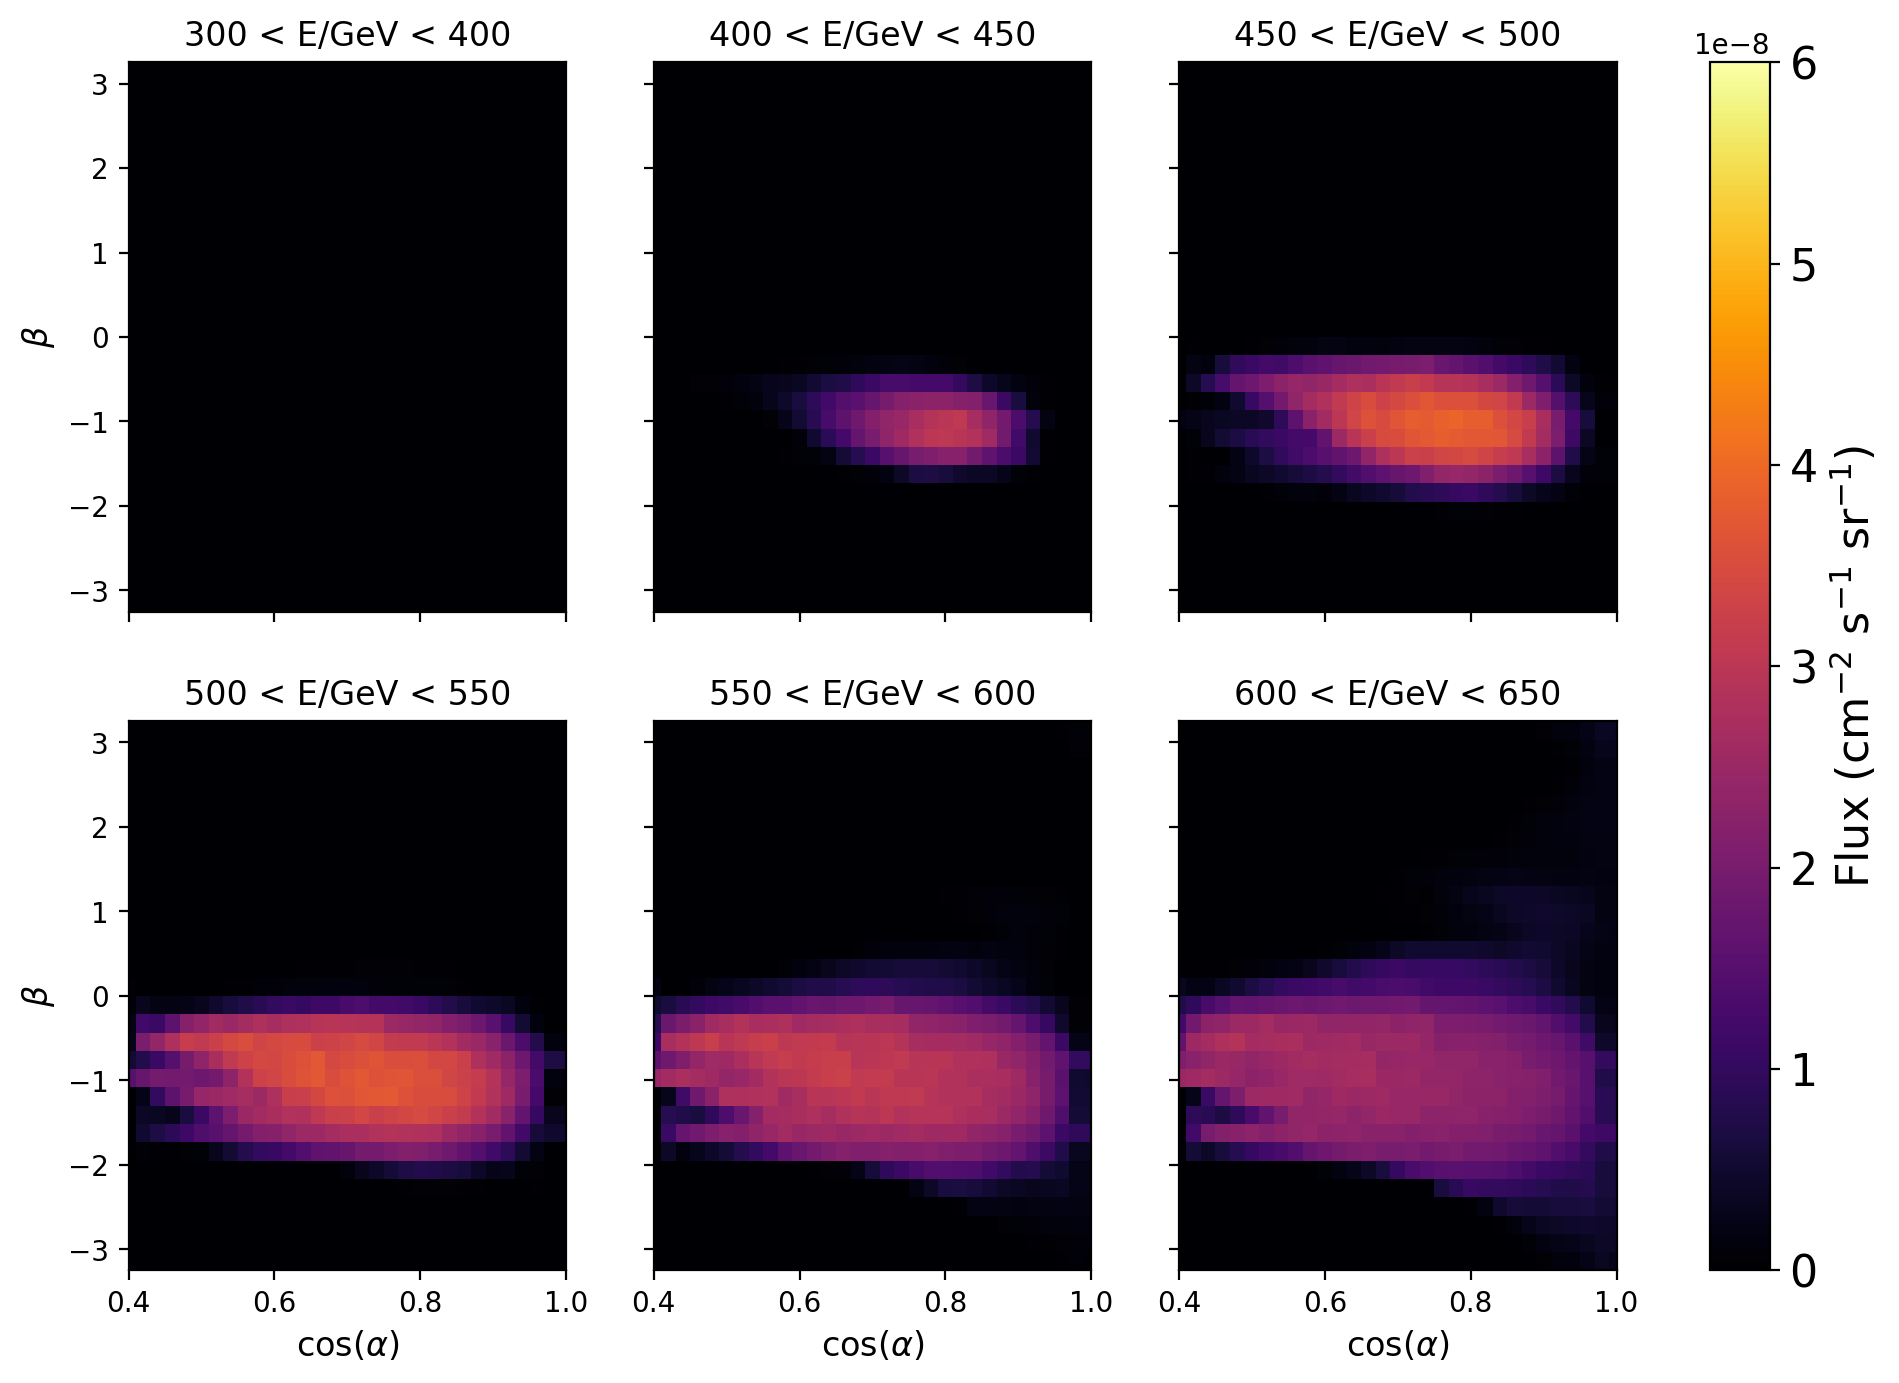

In [5]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,bs,np.transpose(correctedmeshes[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=6e-8)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\beta$",fontsize=12)
axes[0,0].set_ylabel(r"$\beta$",fontsize=12)

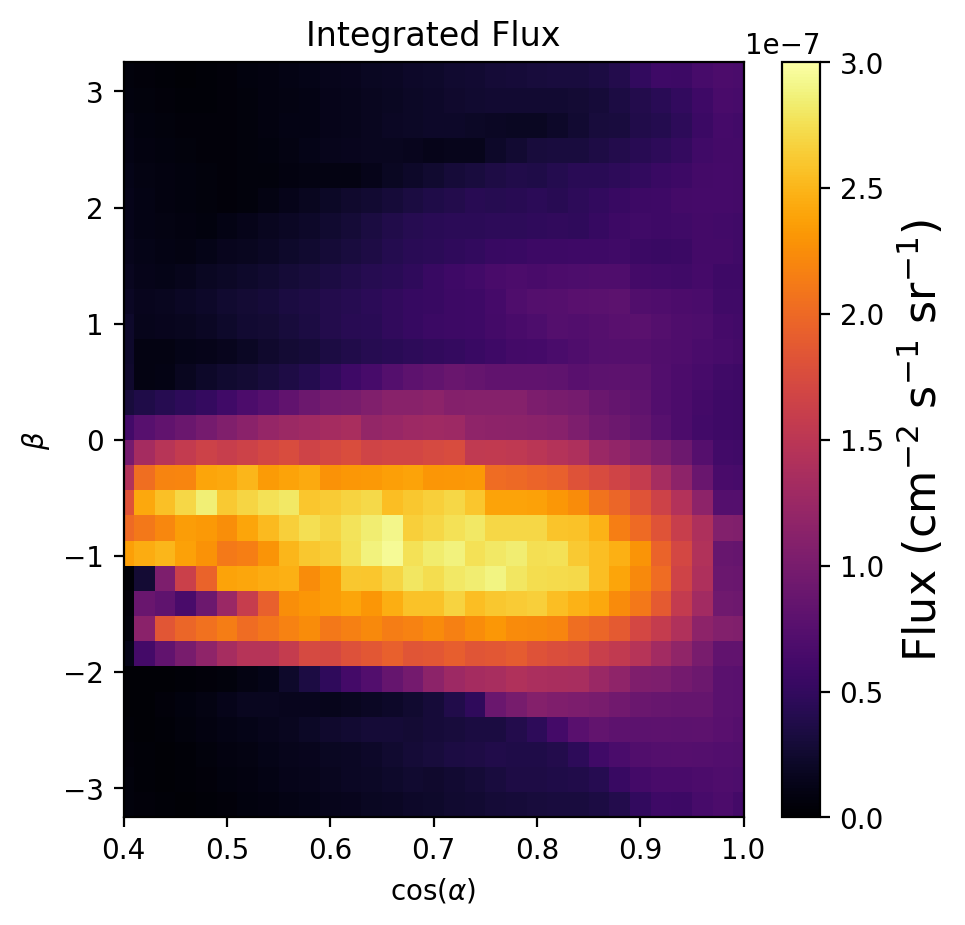

In [6]:
plt.figure(figsize=(5,5),dpi=200)
totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m
im=plt.pcolormesh(cosas,bs,np.transpose(totalflux),cmap='inferno',shading='auto',vmin=0,vmax=3e-7)
ax.set_title("Integrated")

plt.xlabel(r"cos($\alpha$)")
plt.ylabel(r"$\beta$")
plt.xlim(0.4,1)
plt.title("Integrated Flux")
cbar=plt.colorbar()
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)

In [129]:
#cosas,bs,np.transpose(totalflux)

FluxMuons=scipy.interpolate.RectBivariateSpline(np.unique(cosas),np.unique(bs),totalflux,s=0,kx=3, ky=3) 

with open('/Users/rogerslc/Documents/MuFluxPred/TotalFluxInterpolator.pkl', 'wb') as f:
    pickle.dump(FluxMuons, f)

In [351]:

def WeightAtEachPt(Flux,Tau,NumLaunched,Weight):
    InjectArea=np.pi*100**2 #cm
    Tau_sec=Tau*24*60*60 #take from days to seconds
    W= Flux*Tau_sec*InjectArea*(2*NumLaunched/(4*np.pi*.6))**-1*Weight*2
    return W

In [550]:
MCmus=pd.read_hdf("/Users/rogerslc/Documents/MuFluxPred/MCmuonsSelectedSmallerSphere.h5",key="muons")

MCmus.loc[(MCmus.muenergy>2)&(MCmus.perconline>.79)&(MCmus.linelength>73.5)&(MCmus.dEdx<.015),'passed']=True
NumLaunched=len(MCmus.run.unique())*300
print(NumLaunched,len(MCmus)/(NumLaunched),len(MCmus[MCmus.passed==True]))


PassedMC=MCmus[MCmus.passed==True]
PassedMC["MCbeta_diff"]=PassedMC["MCbeta"]-np.pi

311700 0.023557908245107475 503


In [698]:
MuonsFromData=pd.read_hdf('/Users/rogerslc/MuonPredictions/MuonPredictions/CombinedDataMusRunV.h5')
MuonsFromData['beta_rot']=(np.rad2deg(MuonsFromData['beta'])+150)%360

In [552]:
PassedMC["WeightedPts"]=0
        
        
for loc in range(0,len(PassedMC)):
    MCpt=PassedMC.iloc[loc]
    WT=MCpt.Weight
    F=FluxMuons(np.cos(MCpt.MCalpha),MCpt.MCbeta_diff)
    PassedMC["WeightedPts"].iloc[loc]=WeightAtEachPt(F,271.6,NumLaunched,WT)
    #print(WT,F,np.cos(MCpt.MCalpha),MCpt.MCbeta)
    

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()


In [646]:
radius=1000

W=[]
for LOC in range(0,len(PassedMC)):
    alpha=PassedMC['alpha'].iloc[LOC]
    beta=PassedMC['beta'].iloc[LOC] 
    
    xintercept=PassedMC.xintercept.iloc[LOC] 
    yintercept=PassedMC.yintercept.iloc[LOC] 
    zintercept=PassedMC.zintercept.iloc[LOC] 
    
    MCunix=(Rx(radius,alpha,beta))/radius #should be direction of muon
    MCuniy=(Ry(radius,alpha,beta))/radius
    MCuniz=(Rz(radius,alpha,beta))/radius
    
    
    ptofinterx=MCunix*radius+xintercept
    ptofintery=MCuniy*radius+yintercept
    ptofinterz=MCuniz*radius+zintercept 
    
    sphrad=(ptofinterx**2+ptofintery**2+ptofinterz**2)**.5
    sphunix=(ptofinterx)/sphrad
    sphuniy=(ptofintery)/sphrad
    sphuniz=(ptofinterz)/sphrad
    
    PassedMC['Weight'].iloc[LOC]=4*(sphunix*MCunix+sphuniy*MCuniy+sphuniz*MCuniz)
    


/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


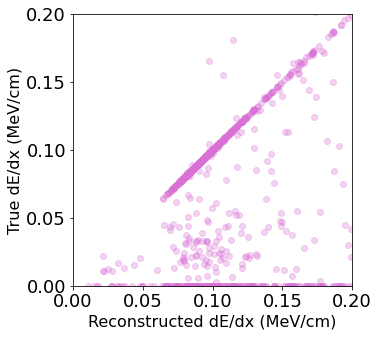

In [639]:
fig = plt.figure(figsize=(5,5))
plt.scatter(MCmus[MCmus.perconline>0].dEdx*10,MCmus[MCmus.perconline>0]["MCdEdx"]*10,alpha=.3,color='orchid')
plt.xlabel("Reconstructed dE/dx (MeV/cm)",fontsize=16)
plt.ylabel("True dE/dx (MeV/cm)",fontsize=16)
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.locator_params(nbins=4)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.savefig('TrueVSrecodEdx.png',dpi=250,bbox_inches='tight')

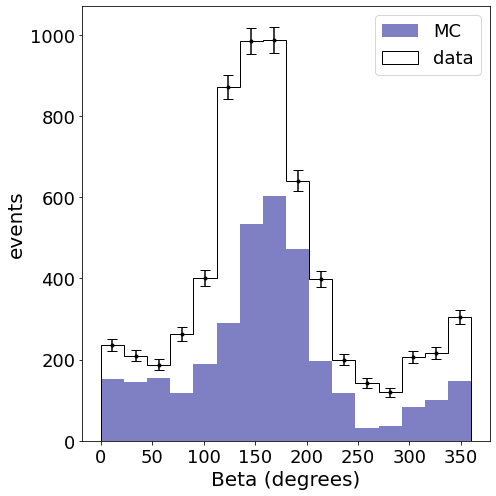

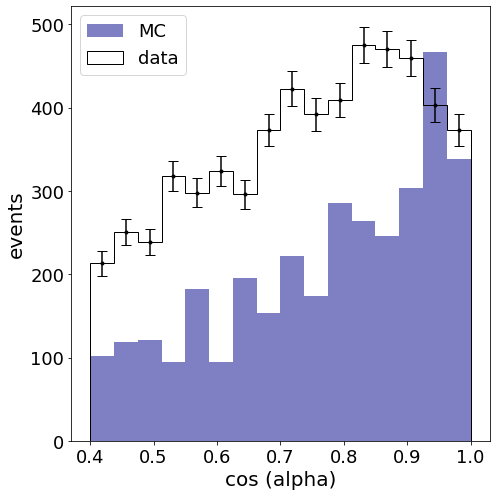

2.1646919342789674 1.9590344387792116


In [699]:
numofsteps=17

plt.figure(figsize=(7,7))
Mh=plt.hist(np.rad2deg(PassedMC['beta']),weights=PassedMC['WeightedPts'],bins=np.linspace(0,360,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
h=plt.hist(MuonsFromData['beta_rot'],bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
#plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.legend(fontsize=18,loc="upper right")
plt.savefig('betahist.png',dpi=250,bbox_inches='tight')
plt.show()

factorbeta=np.mean(h[0]/Mh[0])


plt.figure(figsize=(7,7))
Mh=plt.hist(np.cos(PassedMC['alpha']),weights=PassedMC['WeightedPts'],bins=np.linspace(.4,1,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
h=plt.hist(np.cos(MuonsFromData['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
plt.savefig('alphahist.png',dpi=250,bbox_inches='tight')
plt.show()

factoralpha=np.mean(h[0]/Mh[0])

print(factorbeta,factoralpha)

2.1494377627727683

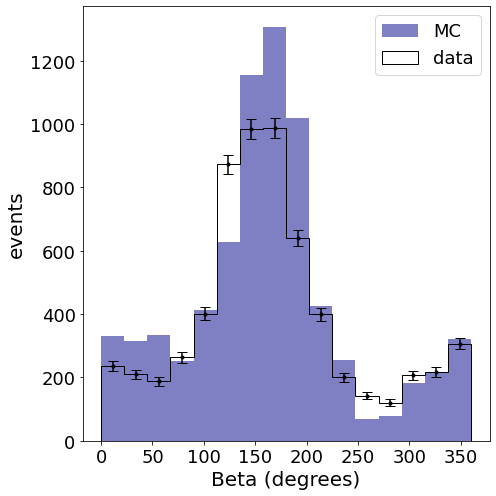

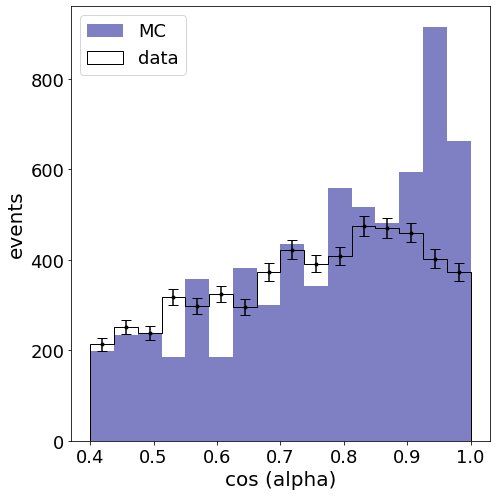

In [700]:
numofsteps=17

plt.figure(figsize=(7,7))
#factorbeta=2.01
plt.hist(np.rad2deg(PassedMC['beta']),weights=PassedMC['WeightedPts']*factorbeta,bins=np.linspace(0,360,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
h=plt.hist(MuonsFromData['beta_rot'],bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
#plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.legend(fontsize=18,loc="upper right")
plt.savefig('betahist_factor.png',dpi=250,bbox_inches='tight')
plt.show()

#factoralpha=2.01
plt.figure(figsize=(7,7))
Mh=plt.hist(np.cos(PassedMC['alpha']),weights=PassedMC['WeightedPts']*factoralpha,bins=np.linspace(.4,1,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
h=plt.hist(np.cos(MuonsFromData['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
plt.savefig('alphahist_factor.png',dpi=250,bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Passed')

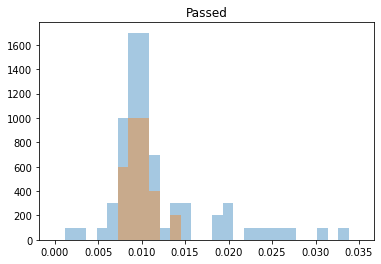

In [442]:
#plt.hist(MuonsFromData.dEdx,bins=np.linspace(0,.035,30),)


plt.hist(MCmus.dEdx,bins=np.linspace(0,.035,30),weights=100*np.ones_like(MCmus.dEdx),alpha=0.4)
plt.hist(PassedMC.dEdx,bins=np.linspace(0,.035,30),weights=100*np.ones_like(PassedMC.dEdx),alpha=0.4)


plt.title('Passed')

Text(0.5, 1.0, 'Passed')

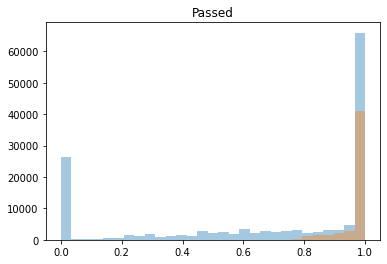

In [690]:
plt.hist(MCmus.perconline,bins=np.linspace(0,1,30),weights=100*np.ones_like(MCmus.dEdx),alpha=0.4)
plt.hist(PassedMC.perconline,bins=np.linspace(0,1,30),weights=100*np.ones_like(PassedMC.dEdx),alpha=0.4)

plt.title('Passed')

Text(0.5, 1.0, 'Passed')

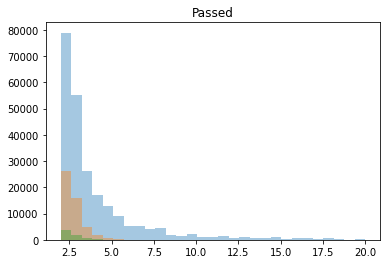

In [689]:
plt.hist(MCmus.muenergy,bins=np.linspace(2,20,30),weights=100*np.ones_like(MCmus.dEdx),alpha=0.4)
plt.hist(PassedMC.muenergy,bins=np.linspace(2,20,30),weights=100*np.ones_like(PassedMC.dEdx),alpha=0.4)
plt.hist(MuonsFromData.muenergy,bins=np.linspace(2,20,30),weights=np.ones_like(MuonsFromData.dEdx),alpha=0.4)
plt.title('Passed')

Text(0.5, 1.0, 'Passed')

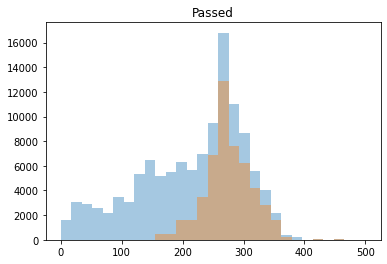

In [688]:
plt.hist(MCmus.linelength,bins=np.linspace(0,500,30),weights=100*np.ones_like(MCmus.dEdx),alpha=0.4)
plt.hist(PassedMC.linelength,bins=np.linspace(0,500,30),weights=100*np.ones_like(PassedMC.dEdx),alpha=0.4)

plt.title('Passed')

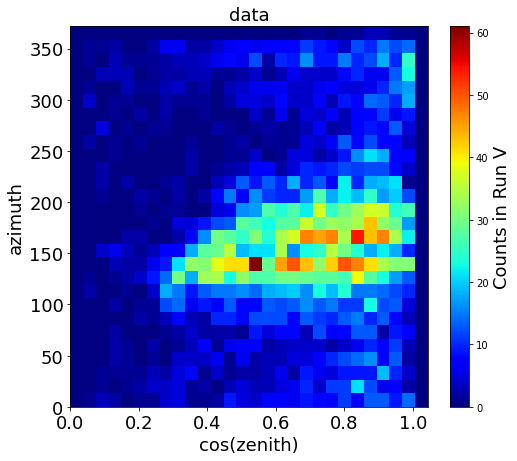

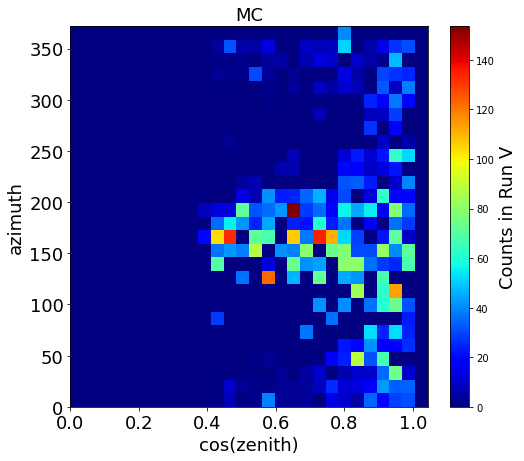

In [701]:

stpsize=30

binsa=np.linspace(0,385,stpsize)
bin_centersa = binsa[:-1] + np.diff(binsa) / 2
bin_edgesa=binsa[:-1] 
binsz=np.linspace(0,1.08,stpsize)
bin_centersz = binsz[:-1] + np.diff(binsz) / 2
bin_edgesz=binsz[:-1] 

plt.figure(figsize=(8,7))
plt.hist2d( np.cos(MuonsFromData['alpha']),MuonsFromData['beta_rot'],bins=[bin_edgesz,bin_edgesa], cmap=plt.cm.jet)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel('azimuth',fontsize=18)
plt.xlabel('cos(zenith)',fontsize=18)
plt.title('data',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
plt.savefig('DataFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,7))
plt.hist2d( np.cos(PassedMC['alpha']),np.rad2deg(PassedMC['beta']),weights=PassedMC['WeightedPts']*factorbeta,bins=[bin_edgesz,bin_edgesa], cmap=plt.cm.jet)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel('azimuth',fontsize=18)
plt.xlabel('cos(zenith)',fontsize=18)
plt.title('MC',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
plt.savefig('MCFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()

In [88]:
l=49 #cm
d=35.6 #cm
fiducial_area=l*d

In [89]:
def onlook_area(cosalpha):
    l=49 #cm
    d=35.6 #cm
    zeta=np.pi/2-np.arccos(cosalpha)
    A=d*l*np.sin(zeta)+np.pi*(d/2)**2*np.cos(zeta)
    return A

/var/folders/jm/hwfgsj_5419b1s2h09k6lflr6k3jsz/T/ipykernel_60602/1323579045.py:4: RuntimeWarning: invalid value encountered in arccos
  zeta=np.pi/2-np.arccos(cosalpha)


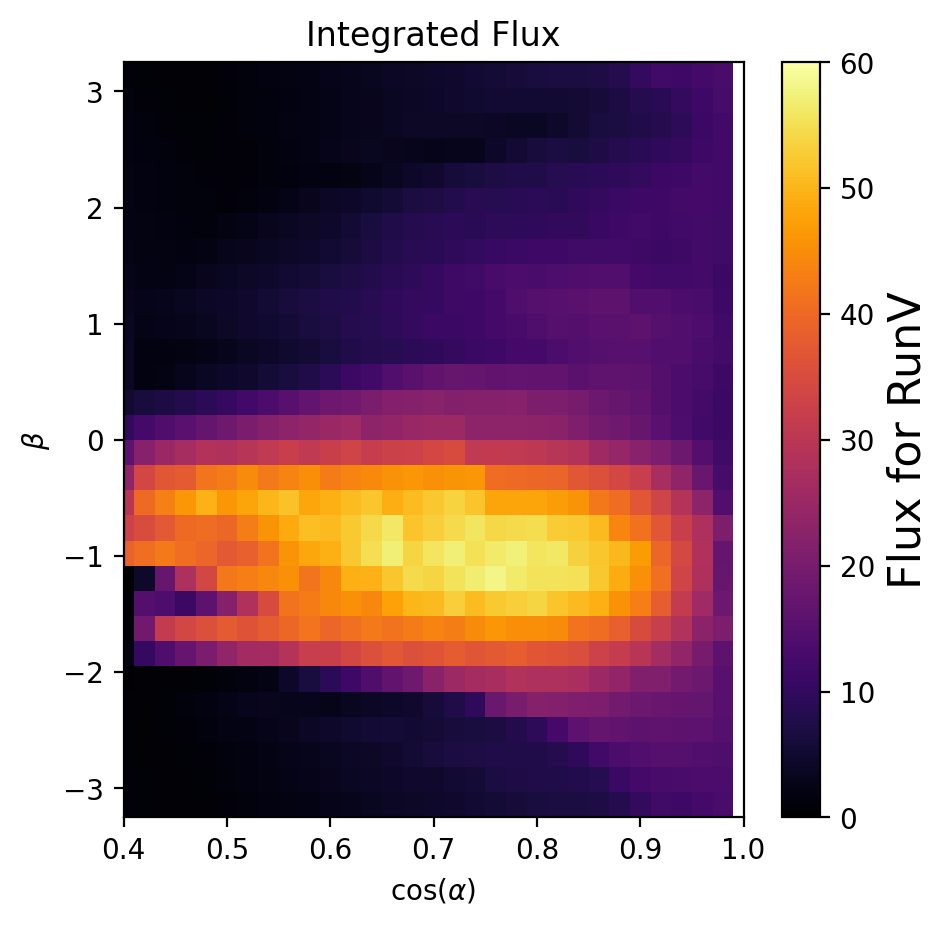

In [488]:
plt.figure(figsize=(5,5),dpi=200)
totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m
ster=np.diff(bs)[0]*np.diff(cosas)[0]
tau=271.6*24*60*60
im=plt.pcolormesh(cosas,bs,np.transpose(totalflux*ster)*onlook_area(cosas)*tau,cmap='inferno',shading='auto',vmin=0,vmax=60)
ax.set_title("Integrated, MCeQ+Proposal")

plt.xlabel(r"cos($\alpha$)")
plt.ylabel(r"$\beta$")
plt.xlim(0.4,1)
plt.title("Integrated Flux")
cbar=plt.colorbar()
cbar.set_label('Flux for RunV',fontsize=16)
plt.savefig("/Users/rogerslc/Documents/MuFluxPred/IntegratedFlux.png",dpi=250,bbox_inches='tight')

(31, 30) (30,) (31,)


In [67]:
len(cosas)

31

In [66]:
len(cos_centersa)

30

In [64]:

cos_centersa=cosas[:-1] + np.diff(cosas) / 2



(0.0, 5e-06)

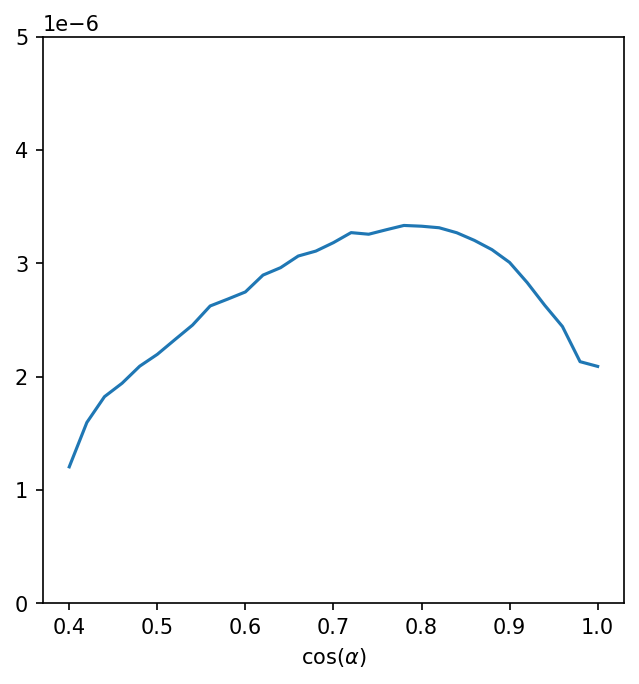

In [7]:
plt.figure(figsize=(5,5),dpi=150)
plt.plot(cosas,[sum(t) for t in totalflux])
plt.xlabel(r"cos($\alpha$)")
plt.ylim(0,5e-6)


Text(0.5, 0, '$\\beta$')

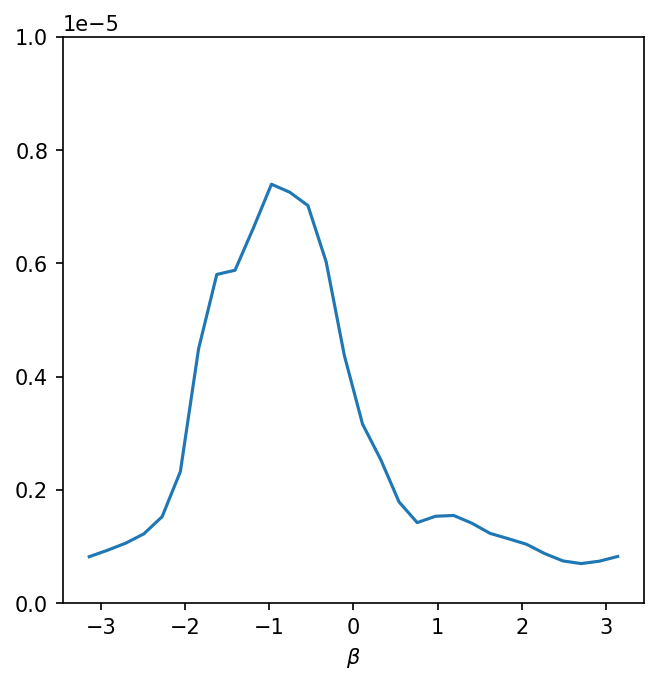

In [8]:

plt.figure(figsize=(5,5),dpi=150)

plt.ylim(0,1e-5)
plt.plot(bs,sum(totalflux))
plt.xlabel(r"$\beta$")

Text(0, 0.5, '$\\beta$')

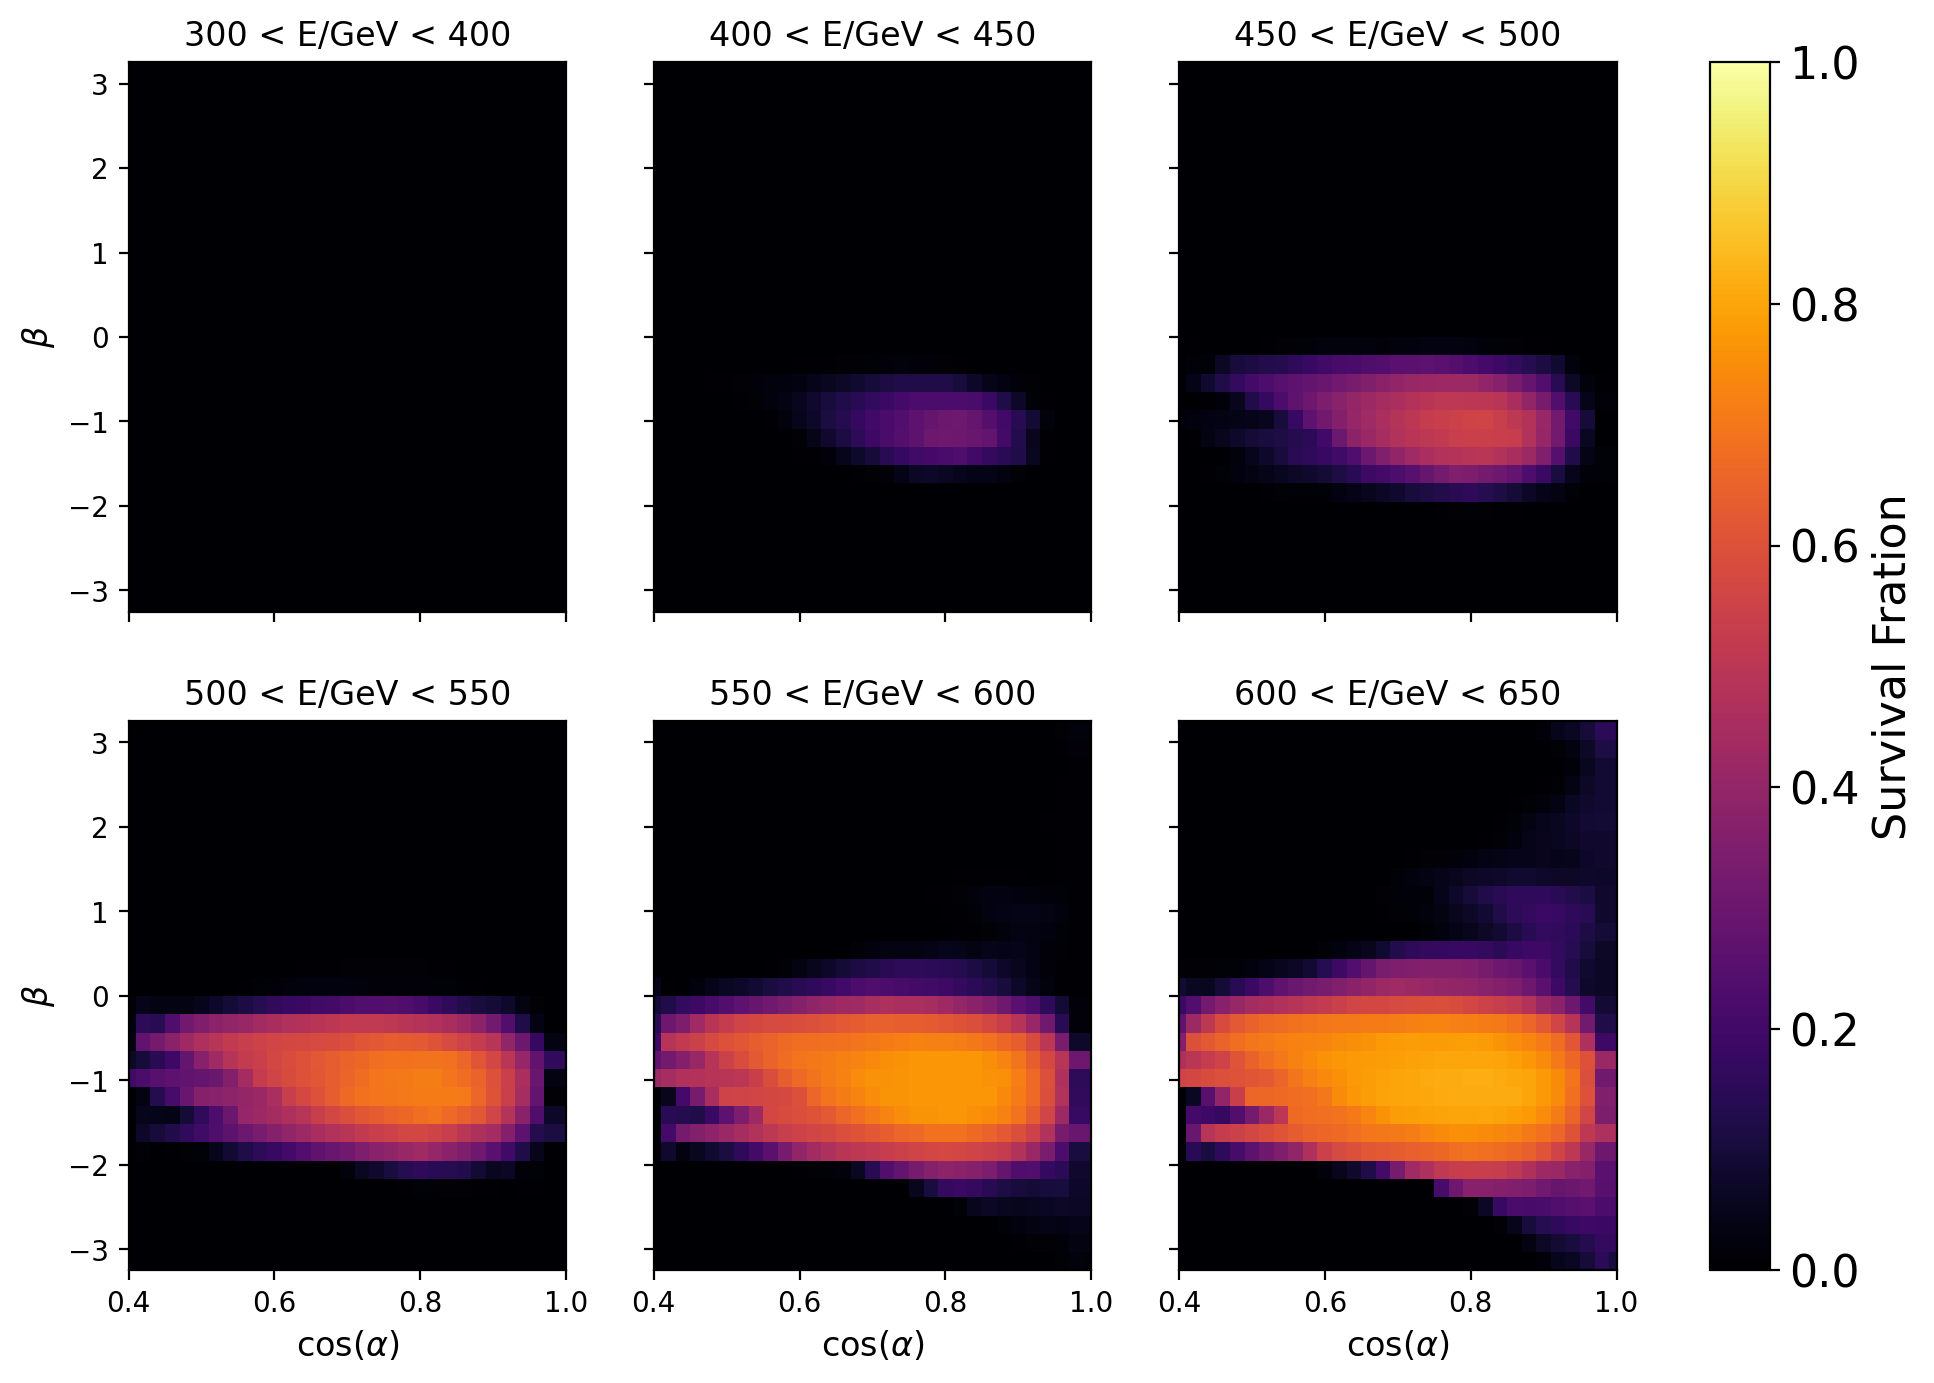

In [536]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,bs,np.transpose(survivalfractions[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=1)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Survival Fration',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\beta$",fontsize=12)
axes[0,0].set_ylabel(r"$\beta$",fontsize=12)

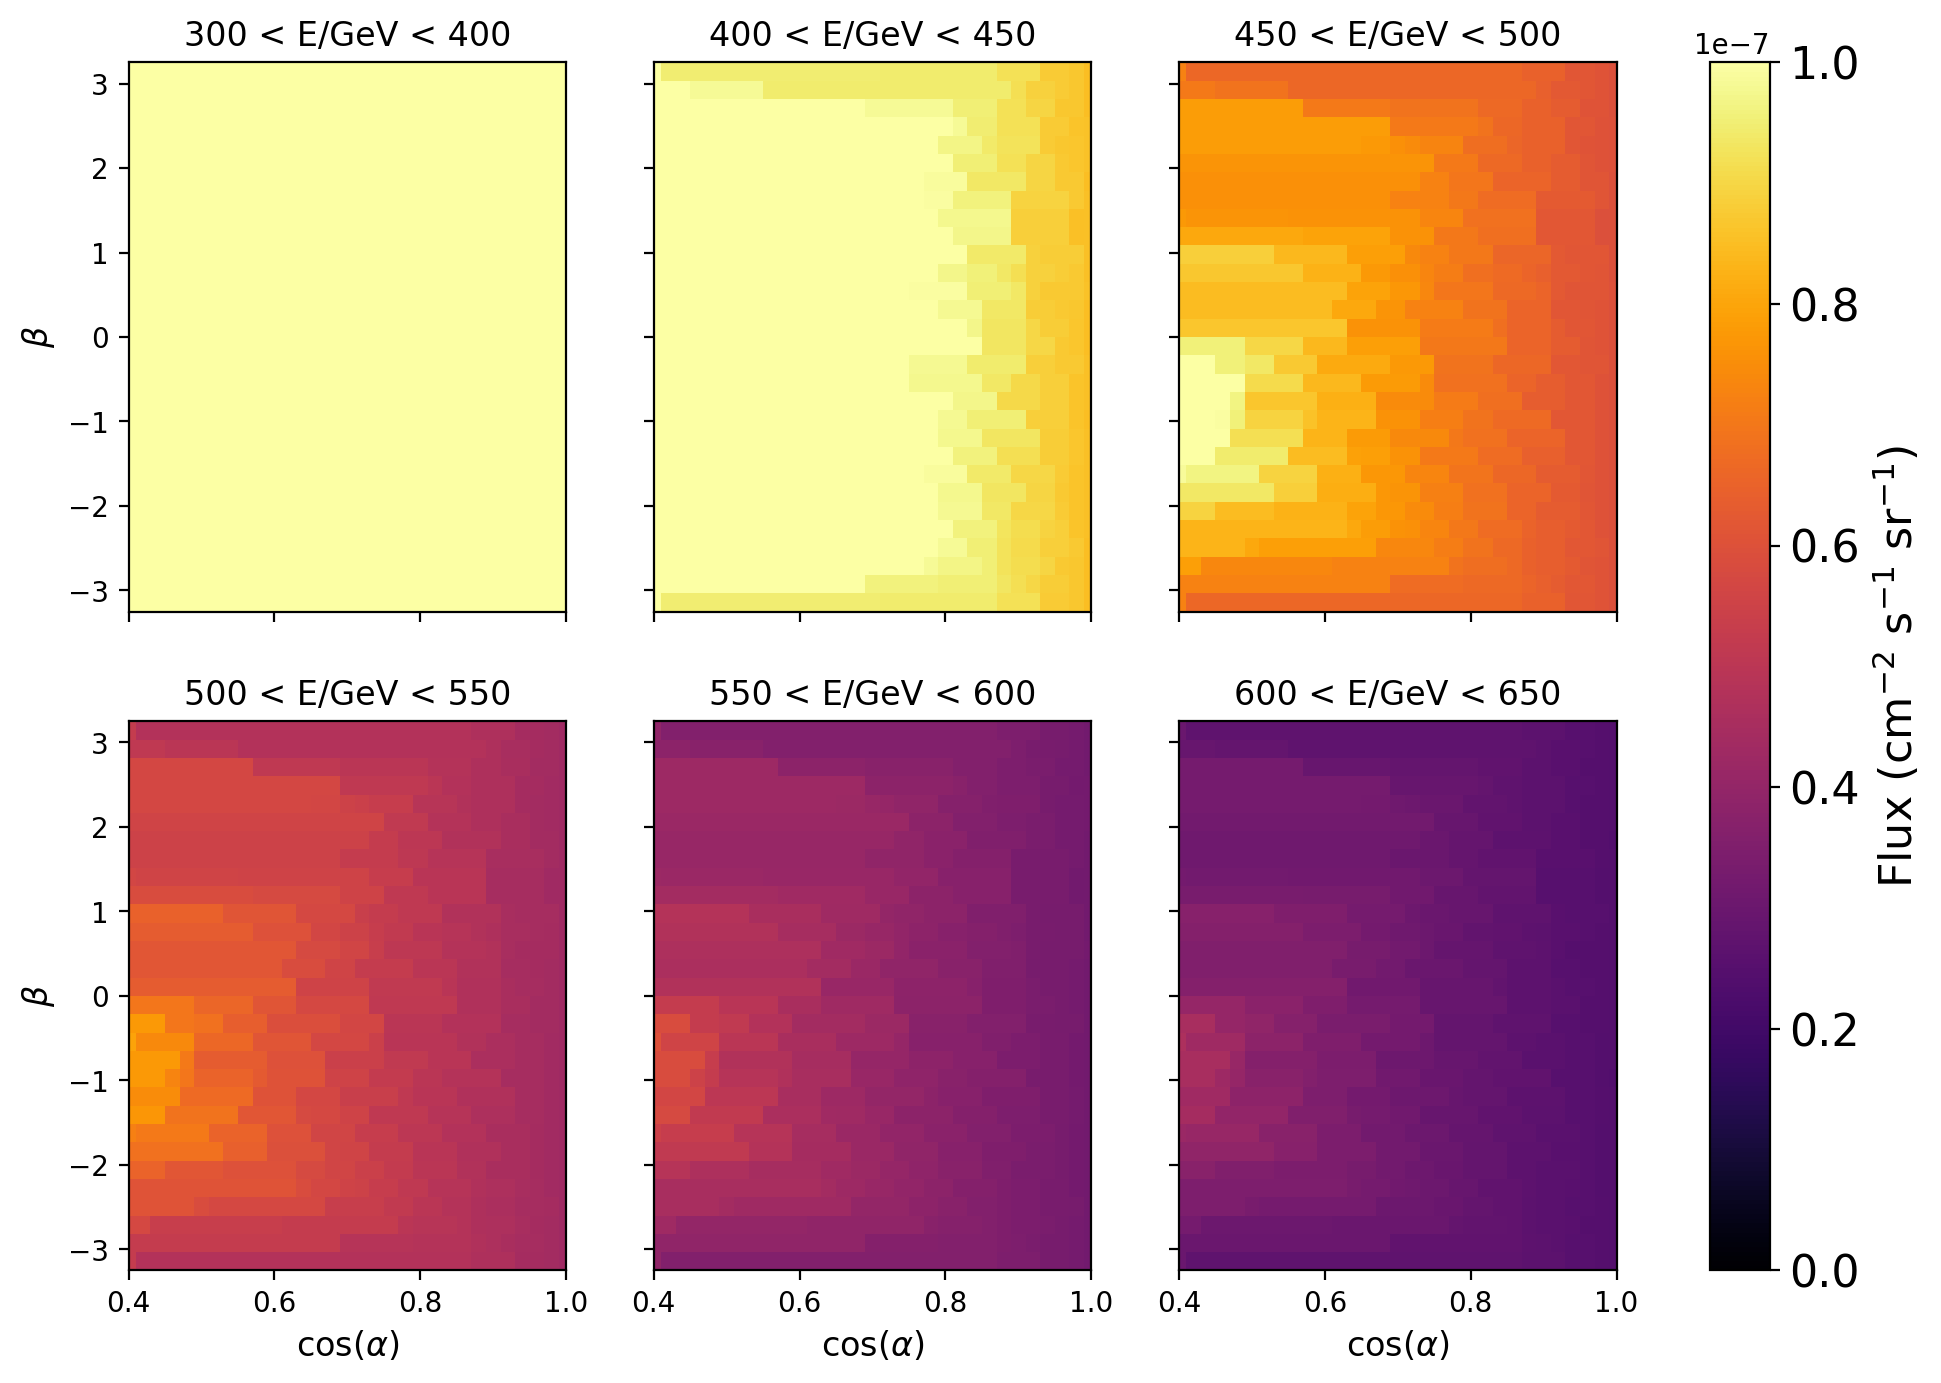

In [539]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,bs,np.transpose(FluxMeshes[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=1e-7)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\beta$",fontsize=12)
axes[0,0].set_ylabel(r"$\beta$",fontsize=12)

plt.savefig('/Users/rogerslc/Documents/MuFluxPred/MCeqFluxes.png',dpi=250,bbox_inches='tight')
plt.show()

In [12]:
cosas

array([0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 ,
       0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82,
       0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [48]:
cosa_mesh, b_mesh=np.meshgrid(cosas,bs)

In [49]:
a_s=np.arccos(cosas-0.001)

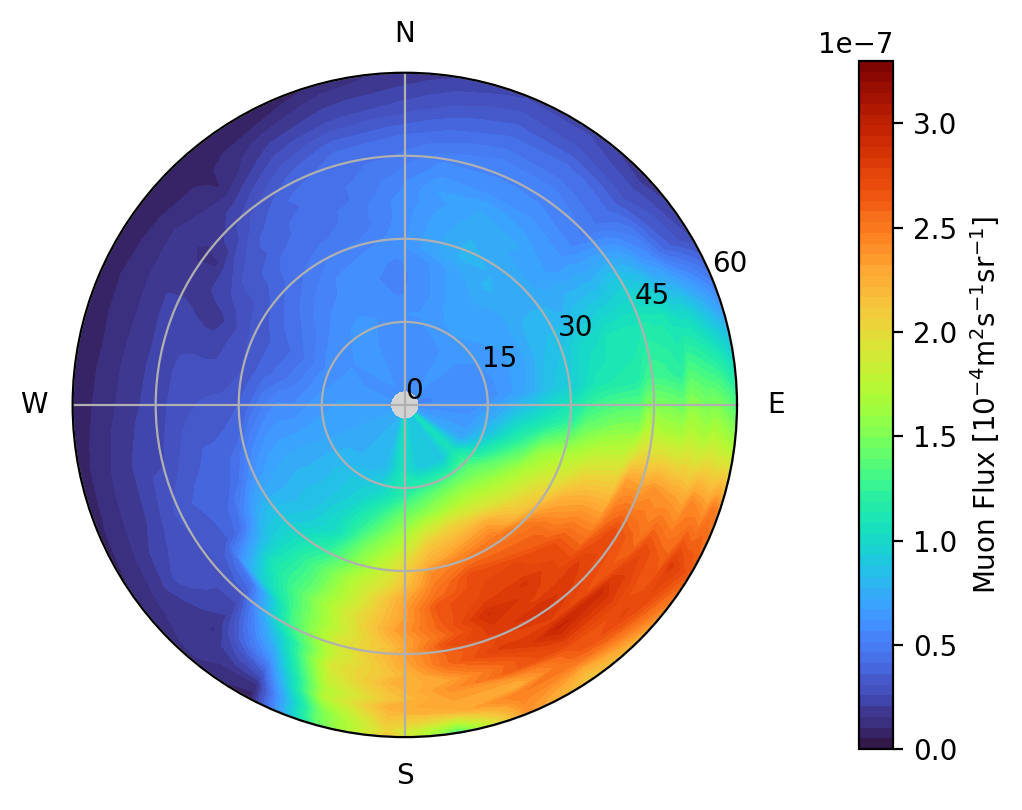

In [507]:

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),constrained_layout=True,figsize=(5,5),dpi=200)
fig.patch.set_facecolor('white')
levels=np.linspace(0,3.3e-7,65)
im=ax.contourf(bs,np.arccos(cosas-0.001)*180/3.14, totalflux,cmap='turbo',levels=levels)
ax.set_rlim(0,60)
ax.set_rticks([0,15,30,45,60])
#plt.savefig("Radars/"+str(ei).zfill(2)+".png",dpi=200)
cb =plt.colorbar(im, shrink=0.7,ticks=np.arange(0,3.5e-7,5e-8))
#cb = fig.colorbar(im, shrink=0.7)
cb.set_label("Muon Flux [10$^{-4}$m$^{2}$s$^{-1}$sr$^{-1}$]")
ax.set_thetagrids([0,90,180,270],['E','N','W','S'])
ax.set(facecolor = "lightgrey",alpha=0.2)
plt.savefig("/Users/rogerslc/Documents/MuFluxPred/PolarFluxes.png",dpi=250,bbox_inches='tight')
plt.show()